## Access SOOP FishSOOP NRT data in Parquet

A jupyter notebook to show how to access and plot SOOP FishSOOP NRT data available as a [Parquet](https://parquet.apache.org) dataset on S3.

More information about the dataset available at [here](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/bdb84466-dc53-49ad-a60f-83d9fa0baed5).

In [1]:
dataset_name = "vessel_fishsoop_realtime_qc"

## Install/Update packages and Load common functions

In [2]:
# only run once, then restart session if needed
!pip install uv

import os
import sys

def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

# Get the current directory of the notebook
current_dir = os.getcwd()

# Check if requirements.txt exists in the current directory
local_requirements = os.path.join(current_dir, 'requirements.txt')
if os.path.exists(local_requirements):
    requirements_path = local_requirements
else:
    # Fall back to the online requirements.txt file
    requirements_path = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/requirements.txt'

# Install packages using uv and the determined requirements file
if is_colab():
    xr.set_options(display_style='text')
    os.system(f'uv pip install --system -r {requirements_path}')
else:
    os.system('uv venv')
    os.system(f'uv pip install -r {requirements_path}')

Using CPython 3.12.6 interpreter at: /home/lbesnard/miniforge3/envs/AodnCloudOptimised/bin/python
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate
Audited 234 packages in 55ms


In [3]:
import requests
import os
if not os.path.exists('DataQuery.py'):
  print('Downloading DataQuery.py')
  url = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/aodn_cloud_optimised/lib/DataQuery.py'
  response = requests.get(url)
  with open('DataQuery.py', 'w') as f:
      f.write(response.text)

In [4]:
from DataQuery import create_time_filter, create_bbox_filter, plot_spatial_extent, get_temporal_extent, get_schema_metadata
import pyarrow.parquet as pq
import pyarrow.dataset as pds
import pandas as pd

## Location of the parquet dataset

In [5]:
BUCKET_OPTIMISED_DEFAULT="aodn-cloud-optimised"
dname = f"s3://anonymous@{BUCKET_OPTIMISED_DEFAULT}/{dataset_name}.parquet/"
parquet_ds = pq.ParquetDataset(dname,partitioning='hive')

# Understanding the Dataset

## Get partition keys
Partitioning in Parquet involves organising data files based on the values of one or more columns, known as partition keys. When data is written to Parquet files with partitioning enabled, the files are physically stored in a directory structure that reflects the partition keys. This directory structure makes it easier to retrieve and process specific subsets of data based on the partition keys.

In [6]:
dataset = pds.dataset(dname, format="parquet", partitioning="hive")

partition_keys = dataset.partitioning.schema
print(partition_keys)

timestamp: int32
polygon: string


## Visualise Spatial Extent of the dataset
In this section, we're plotting the polygons where data exists. This helps then with creating a bounding box where there is data

/home/lbesnard/miniforge3/envs/AodnCloudOptimised/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/DataQuery.py:442: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/DataQuery.py:442: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


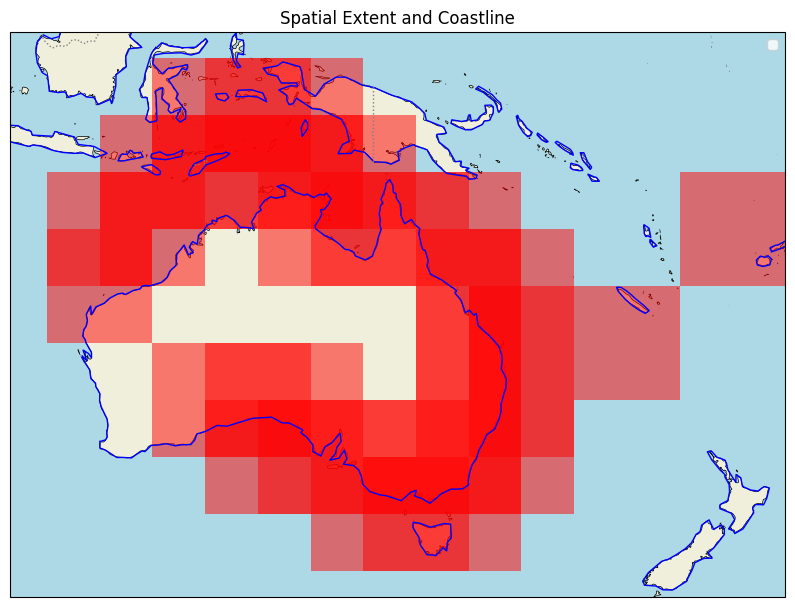

In [7]:
plot_spatial_extent(parquet_ds)

## Get Temporal Extent of the dataset

Similary to the spatial extent, we're retrieving the minimum and maximum timestamp partition values of the dataset. This is not necessarely accurately representative of the TIME values, as the timestamp partition can be yearly/monthly... but is here to give an idea

In [8]:
get_temporal_extent(parquet_ds)

(datetime.datetime(2021, 11, 1, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2025, 1, 1, 0, 0, tzinfo=datetime.timezone.utc))

## Read Metadata

For all parquet dataset, we create a sidecar file in the root of the dataset named **_common_matadata**. This contains the variable attributes.

In [9]:
# parquet_meta = pa.parquet.read_schema(os.path.join(dname + '_common_metadata'))  # parquet metadata
metadata = get_schema_metadata(dname)  # schema metadata
metadata

{'TRAJECTORY_ID': {'type': 'double',
  'long_name': 'trajectory identifier',
  'cf_role': 'trajectory_id'},
 'TIME': {'type': 'timestamp[ns]',
  'standard_name': 'time',
  'long_name': 'time',
  'axis': 'T',
  'valid_min': 21915.0,
  'valid_max': 90000.0,
  'comment': 'The valid_min is set to January 1st, 2010, dates before this time are flagged by the quality control impossible date test'},
 'LATITUDE': {'type': 'float',
  'ancillary_variables': 'LATITUDE_quality_control',
  'standard_name': 'latitude',
  'long_name': 'latitude',
  'units': 'degrees_north',
  'valid_min': -90.0,
  'valid_max': 90.0,
  'axis': 'Y',
  'reference_datum': 'WGS84 geographic coordinate system'},
 'LATITUDE_quality_control': {'type': 'int32',
  'long_name': 'quality flag for latitude',
  'standard_name': 'latitude status_flag',
  'quality_control_conventions': 'IMOS standard flags',
  'flag_values': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
  'flag_meanings': 'No_QC_performed Good_data Probably_good_data Bad_data_that

# Data Query and Plot

## Create a TIME and BoundingBox filter

In [10]:
filter_time = create_time_filter(parquet_ds, date_start='2021-01-31 10:14:00', date_end='2023-09-01 07:50:00')
filter_geo = create_bbox_filter(parquet_ds, lat_min=-40, lat_max=-32, lon_min=130, lon_max=150)


filter = filter_geo & filter_time

In [11]:
%%time
# using pandas instead of pyarrow so that filters can directly be applied to the data, and not just the partition
df = pd.read_parquet(dname, engine='pyarrow',filters=filter)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85601 entries, 0 to 85600
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   TRAJECTORY_ID                85601 non-null  float64       
 1   TIME                         85601 non-null  datetime64[ns]
 2   LATITUDE                     85601 non-null  float32       
 3   LATITUDE_quality_control     85601 non-null  int32         
 4   LONGITUDE                    85601 non-null  float32       
 5   LONGITUDE_quality_control    85601 non-null  int32         
 6   DEPTH                        85601 non-null  float32       
 7   DEPTH_quality_control        85601 non-null  int32         
 8   TEMPERATURE                  85601 non-null  float32       
 9   TEMPERATURE_quality_control  85601 non-null  int32         
 10  PRES                         85601 non-null  float32       
 11  PRES_quality_control         85601 non-nu

<Axes: xlabel='latitude', ylabel='depth'>

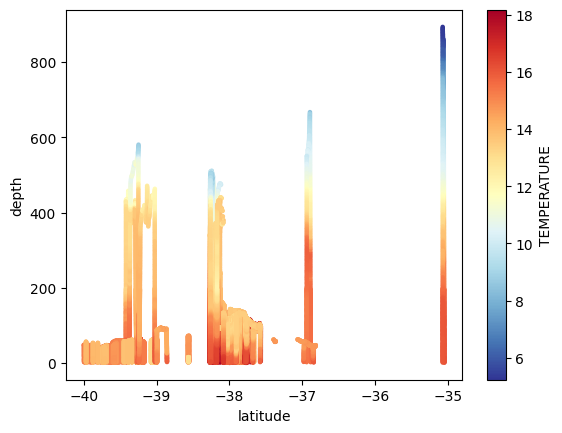

In [12]:
df[df['TEMPERATURE_quality_control'] == 1].sort_values('TIME').plot.scatter(x='LATITUDE', y='DEPTH', c='TEMPERATURE', 
                                                                     xlabel=metadata['LATITUDE']['standard_name'],
                                                                     ylabel=metadata['DEPTH']['standard_name'],
                                                                     cmap='RdYlBu_r', marker='.', linestyle="None")


<Axes: xlabel='longitude', ylabel='depth'>

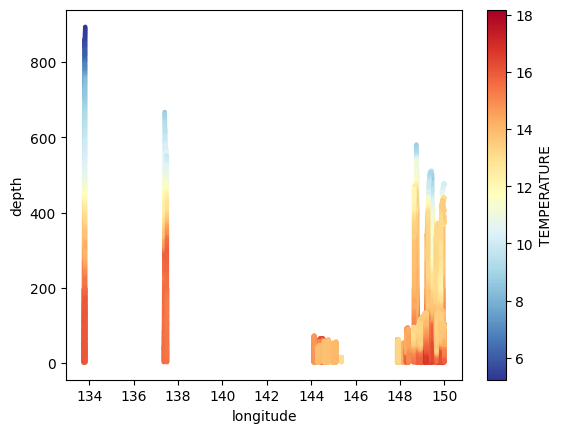

In [13]:
df[df['TEMPERATURE_quality_control'] == 1].sort_values('TIME').plot.scatter(x='LONGITUDE', y='DEPTH', c='TEMPERATURE', 
                                                                     xlabel=metadata['LONGITUDE']['standard_name'],
                                                                     ylabel=metadata['DEPTH']['standard_name'],
                                                                     cmap='RdYlBu_r', marker='.', linestyle="None")

## Create a 3D plot of the Temperature

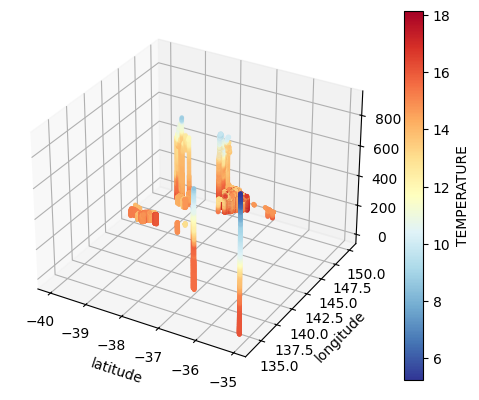

In [14]:
import matplotlib.pyplot as plt

filtered_df = df[df['TEMPERATURE_quality_control'] == 1].sort_values('TIME')

latitude = filtered_df['LATITUDE']
longitude = filtered_df['LONGITUDE']
depth = filtered_df['DEPTH']
temperature = filtered_df['TEMPERATURE']

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(latitude, longitude, depth, c=temperature, cmap='RdYlBu_r', marker='.')

# Add labels
ax.set_xlabel(metadata['LATITUDE']['standard_name'])
ax.set_ylabel(metadata['LONGITUDE']['standard_name'])
ax.set_zlabel(metadata['DEPTH']['standard_name'])

cbar = plt.colorbar(sc)
cbar.set_label('TEMPERATURE')

plt.show()